# File loading, trial extraction, preprocessing

In [ ]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
from scipy.signal import butter, filtfilt
import numpy as np


#Segmentation parameters
window_sec = 3
overlap_ratio = 0.5
overlap_sec = window_sec * overlap_ratio

#Preprocessing BPF parameters
lowcut = 20
highcut = 400
order = 4

#BPF function
def bandpass_filter(signal, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    #Butterworth filter
    b, a = butter(order, [low, high], btype='band')
    #Non-causal filtering
    return filtfilt(b, a, signal)
    

#Segmentation (trial extraction) function
def segment_signal(y, fs, window_sec, overlap_sec):
    window_len = int(window_sec * fs)
    stride_len = window_len - int(overlap_sec * fs)
    
    segments = []
    for start in range(0, len(y) - window_len + 1, stride_len):
        end = start + window_len
        segment = y[start:end]
        segments.append(segment)
    return segments


#NaN checking and correction function
def NaN_checking(signal):
    print('NaN checking')
    if np.isnan(signal).any():
        is_nan_array = np.isnan(signal)
        nan_index = np.where(is_nan_array == True)[0]
        for index in nan_index:
            if index == 0:
                signal[index] = 0
            else:
                #Forward imputation
                signal[index] = signal[index-1]
    else:
        print('No NaN found')
    return signal
    

#Trial rejection function
def artifact_trial_rejection(train_trials, threshold):
    artefact_index = []
    for i in range(len(train_trials)):
        #Amplitude thresholding
        if np.max(np.abs(train_trials[i])) > threshold:
            artefact_index.append(i)
   
    print(f'number of removed artefactual trials: {len(artefact_index)}' )

    return artefact_index

#Trial normalization via z scoring
def normalize_segment_zscore(segment):
    return (segment - np.mean(segment)) / (np.std(segment) + 1e-8)

folder_path_storage = ['Data/normal/', 'Data/murmur/', 'Data/artifact/']
segments_storage = []
labels_storage = []
file_ID_storage = []
fileID = 1
for folder_path in folder_path_storage:
    file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    if folder_path == 'Data/normal/':
        label = 0
    elif folder_path == 'Data/murmur/':
        label = 1
    elif folder_path == 'Data/artifact/':
        label = 2

    for file in file_list:
        print(file)
        #File loading
        y,sr = librosa.load(file, sr=1000)
        #NaN checking and correction
        NaN_checked_signal = NaN_checking(y)
        #Band pass filtering
        bpf_output = bandpass_filter(NaN_checked_signal, lowcut, highcut, sr, order)
        #Trial extraction and labelling
        segments = segment_signal(bpf_output, sr, window_sec, overlap_sec)
        for seg in segments:
            segments_storage.append(seg)
            labels_storage.append(label) 
            file_ID_storage.append(fileID)

        fileID = fileID + 1


Trials = np.stack(segments_storage)  
Labels = np.array(labels_storage) 
File_ID = np.array(file_ID_storage)

for i in range(len(Trials)):
    Trials[i] = normalize_segment_zscore(Trials[i])

In [39]:
#Sanity checking

print(f'number of labels: {len(labels_storage)}')
print(f'number of trials: {len(segments_storage)}')

#print class distribution
print(f'number of normal trials: {np.sum(Labels == 0)}' )
print(f'number of murmur trials: {np.sum(Labels == 1)}' )
print(f'number of artifact trials: {np.sum(Labels == 2)}' )


number of labels: 451
number of trials: 451
number of normal trials: 122
number of murmur trials: 129
number of artifact trials: 200


# Features extraction

In [40]:
from scipy.signal import hilbert, find_peaks
from scipy.stats import entropy as scipy_entropy
from scipy.signal import savgol_filter
from scipy.signal import welch
from scipy.signal import find_peaks


#Function to extract time domain features 
def extract_time_domain_features(signal, sr):
    #Envelope extraction with hilbert transform
    envelope = np.abs(hilbert(signal))
    #Smoothing of envelope
    smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)
    #Feature 1: envelope mean
    envelope_mean = np.mean(smoothed_env)
    #Feature 2: envelope variance
    envelope_variance = np.var(smoothed_env)

    N = len(smoothed_env)
    freqs = np.fft.rfftfreq(N, 1/sr)
    fft_vals = np.abs(np.fft.rfft(smoothed_env))
    #Feature 3: dominant frequency of envelope via fft
    envelope_dom_freq = freqs[np.argmax(fft_vals[1:]) + 1] 

    #Feature 4: number of peaks on envelope
    peaks, _ = find_peaks(smoothed_env, height=0.5 * np.max(smoothed_env))
    envelope_peaks = len(peaks)

    # Feature 5: rms of signal
    rms_energy = np.sqrt(np.mean(signal ** 2))
    # Feature 6: peak to peak of signal
    p2p = np.max(signal) - np.min(signal)

    hist, bin_edges = np.histogram(signal, bins=50, density=True)
    #Feature 7: signal entropy computed on histogram
    signal_entropy = scipy_entropy(hist + 1e-8)  

    return np.array([envelope_mean, envelope_variance, envelope_dom_freq, p2p, rms_energy, signal_entropy, envelope_peaks])

#Function to extract frequency domain features 
def extract_frequency_domain_features(signal, sr):
    #Frequency features extracted from PSD estimated from Welch
    freqs_psd, psd = welch(signal, fs=sr, nperseg=1024)
    freq_res = freqs_psd[1] - freqs_psd[0]
    #Bandpower computations
    band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
    band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)
    bp_25_150 = np.sum(psd[band_25_150]) * freq_res
    bp_150_400 = np.sum(psd[band_150_400]) * freq_res
    #Feature 1: band power ratio
    bandpower_ratio = bp_150_400/(bp_25_150 + 1e-8)

    centroid = np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8)
    #Feature 2: signal bandwidth
    bandwidth = np.sqrt(np.sum(((freqs_psd - centroid) ** 2) * psd) / (np.sum(psd) + 1e-8))
    #Feature 3: dominant frequency on PSD
    dominant_freq = freqs_psd[np.argmax(psd[1:]) + 1]

    #Feature 4: Spectral entropy computed on normalized PSD values
    norm_psd = psd / np.sum(psd)
    spectral_entropy = scipy_entropy(norm_psd)

    return np.array([bandpower_ratio, bandwidth, dominant_freq, spectral_entropy])

features = []
for trial in Trials: 
    time_features = extract_time_domain_features(trial, sr=1000)
    freq_features = extract_frequency_domain_features(trial, sr=1000)
    features_vector = np.concatenate((time_features, freq_features))
    features.append(features_vector)

features = np.stack(features)


# Dataset splitting

In [41]:
import random
from sklearn.model_selection import StratifiedShuffleSplit

#sanity checking
print('shape of features:', features.shape)

#If true, trials belonging to the file will be in the same set. 
file_level_splitting = True

if file_level_splitting == False:
    from sklearn.model_selection import StratifiedShuffleSplit
    #Stratified split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=100)
    for train_idx, test_idx in sss.split(features, Labels):
        train_set, test_set = features[train_idx], features[test_idx]
        train_set_labels, test_set_labels = Labels[train_idx], Labels[test_idx]
        
    print('shape of train set:', train_set.shape)
    print('shape of test set:', test_set.shape)


else: 

    unique_files, file_indices = np.unique(File_ID, return_index=True)
    file_labels = Labels[file_indices]  
    #Stratified split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=100)
    for train_file_idx, test_file_idx in sss.split(unique_files, file_labels):
        train_file_ids = unique_files[train_file_idx]
        test_file_ids = unique_files[test_file_idx]
    
    train_mask = np.isin(File_ID, train_file_ids)
    test_mask = np.isin(File_ID, test_file_ids)
    
    train_set = features[train_mask]
    train_set_labels = Labels[train_mask]
    train_files = File_ID[train_mask]
    test_set = features[test_mask]
    test_set_labels = Labels[test_mask]
    test_files = File_ID[test_mask]
    
    # Sanity check
    print('shape of train set:', train_set.shape)
    print('shape of test set:', test_set.shape)

shape of features: (451, 11)
shape of train set: (359, 11)
shape of test set: (92, 11)


In [42]:
#Trial rejection via amplitude thresholding on training data
#This is part of preprocessing. It's here after train-test splitting to make sure outlier rejection only done on train set. 

peak_amps = [np.max(np.abs(trial)) for trial in Trials[train_mask]]
threshold = np.percentile(peak_amps, 99.5)
print(threshold)

#Reject trials that have amplitudes surpass 99.5% threshold
artifact_trials =  artifact_trial_rejection(Trials[train_mask],threshold)
train_set = np.delete(train_set, artifact_trials, axis = 0)
train_set_labels = np.delete(train_set_labels, artifact_trials)
train_files = np.delete(train_files, artifact_trials)
print('shape of train set:', train_set.shape)

32.72076781436819
number of removed artefactual trials: 2
shape of train set: (357, 11)


# Stage 1, 3 class classifier

In [ ]:
#Model building and hyperparameter tuning of the 3-class classifier

import optuna
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold

print(f'Train set shape: {train_set.shape}')

def objective(trial):
    
    #Choose between SVM and XGBoost
    model_type = trial.suggest_categorical('model_type', ['svm', 'xgboost'])

    #File level data splitting between training and validation folds
    if file_level_splitting == True:
        skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(train_set, train_set_labels, groups=train_files)
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(train_set, train_set_labels)
    
    f1_scores = []

    #hyperparameters to be tuned
    if model_type == 'svm':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        gamma = 'scale' if kernel == 'linear' else trial.suggest_float('gamma', 1e-4, 1e1, log=True)
        #Class weights for class imbalance
        w0 = trial.suggest_float('w0', 0.1, 10.0)
        w1 = trial.suggest_float('w1', 0.1, 10.0)
        w2 = trial.suggest_float('w2', 0.1, 10.0)
        class_weights = {0: w0, 1: w1, 2: w2}
        
    else:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    for train_idx, val_idx in split_generator:
        X_train, X_val = train_set[train_idx], train_set[val_idx]
        y_train, y_val = train_set_labels[train_idx], train_set_labels[val_idx]

        # Features normalization
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        if model_type == 'svm':
            clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weights)
        else:
            clf = xgb.XGBClassifier(
                objective='multi:softprob',
                num_class=3,
                use_label_encoder=False,
                eval_metric='mlogloss',
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                scale_pos_weight=1
            )

        clf.fit(X_train, y_train)
        if model_type == 'xgboost':
            y_pred = np.argmax(clf.predict_proba(X_val), axis=1)
        else:
            y_pred = clf.predict(X_val)

        f1 = f1_score(y_val, y_pred, average='macro')
        #f1 = f1_score(y_val, y_pred, labels=[0, 1], average='macro')

        #Optional metrics that can be optimized by Optuna
        true_healthy_idx = np.where(y_val == 0)[0]
        if len(true_healthy_idx) > 0:
            num_healthy_misclassified_as_murmur = np.sum(y_pred[true_healthy_idx] == 1)
            fpr_healthy_to_murmur = num_healthy_misclassified_as_murmur / len(true_healthy_idx)

        f1_scores.append(f1)

    return np.mean(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


# Stage 2, 2 class (Healthy vs Murmur) classifier

In [ ]:
#The model structure and tuning follows that of stage 1 classifier
from sklearn.metrics import accuracy_score

def objective_secondary(trial):

    #Hyperparameters to be tuned
    model_type = trial.suggest_categorical('model_type', ['svm', 'xgboost'])
    
    if model_type == 'svm':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        gamma = 'scale' if kernel == 'linear' else trial.suggest_float('gamma', 1e-4, 1e1, log=True)
        w0 = trial.suggest_float('w0', 0.1, 10.0)
        w1 = trial.suggest_float('w1', 0.1, 10.0)
        class_weights = {0: w0, 1: w1}
        
    else:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    #This model is fine tuned to healthy vs murmur
    binary_mask = np.isin(train_set_labels, [0,1])
    binary_train_set = train_set[binary_mask]
    binary_train_labels = train_set_labels[binary_mask]

    #File level splitting in CV
    if file_level_splitting == True:
        skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(binary_train_set, binary_train_labels, groups=train_files[binary_mask])
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
        split_generator = skf.split(binary_train_set, binary_train_labels)
        
    f1_scores = []
    
    for train_idx, val_idx in split_generator:
        X_train, X_val = binary_train_set[train_idx], binary_train_set[val_idx]
        y_train, y_val = binary_train_labels[train_idx], binary_train_labels[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        if model_type == 'svm':
            clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weights)
        else:
            clf = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='mlogloss',
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            scale_pos_weight=1
            )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred, labels=[0, 1], average='macro')
        accuracy = accuracy_score(y_val, y_pred)

        #Other metrics that can be optimized by Optuna, i.e. healthy -> murmur misclassification rate 
        true_healthy_idx = np.where(y_val == 0)[0]
        num_healthy = len(true_healthy_idx)
        num_healthy_misclassified_as_murmur = np.sum(y_pred[true_healthy_idx] == 1)
        fpr_healthy_to_murmur = num_healthy_misclassified_as_murmur / num_healthy

        true_murmur_idx = np.where(y_val == 1)[0]
        num_murmur = len(true_murmur_idx)
        num_murmur_misclassified_as_healthy = np.sum(y_pred[true_murmur_idx] == 0)
        fpr_murmur_to_healthy = num_murmur_misclassified_as_healthy / num_murmur
        
        f1_scores.append(f1)

    return np.mean(f1_scores)

study_secondary_classifier = optuna.create_study(direction='maximize')
study_secondary_classifier.optimize(objective_secondary, n_trials=70)

# Evaluate: Test set performance

/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:19:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stage 1 classifer, Test macro F1: 0.8042327037455567
Stage 1 classifer, Overall test accuracy: 0.8369565217391305
Stage 1 classifer, Healthy accuracy: 0.5833333333333334
healthy sample size: 24
Stage 1 classifer, Murmur accuracy: 0.8571428571428571
murmur sample size: 28
Stage 1 classifer, Artifact accuracy: 0.975
artifact sample size: 40
Stage 1 classifer, Healthy precision: 0.7368421052631579
Stage 1 classifier, Murmur precision: 0.7058823529411765
Stage 1 classifier, Artifact precision: 1.0
Stage 1 classifer, Healthy recall: 0.5833333333333334
Stage 1 classifier, Murmur recall: 0.8571428571428571
Stage 1 classifier, Artifact recall: 0.975


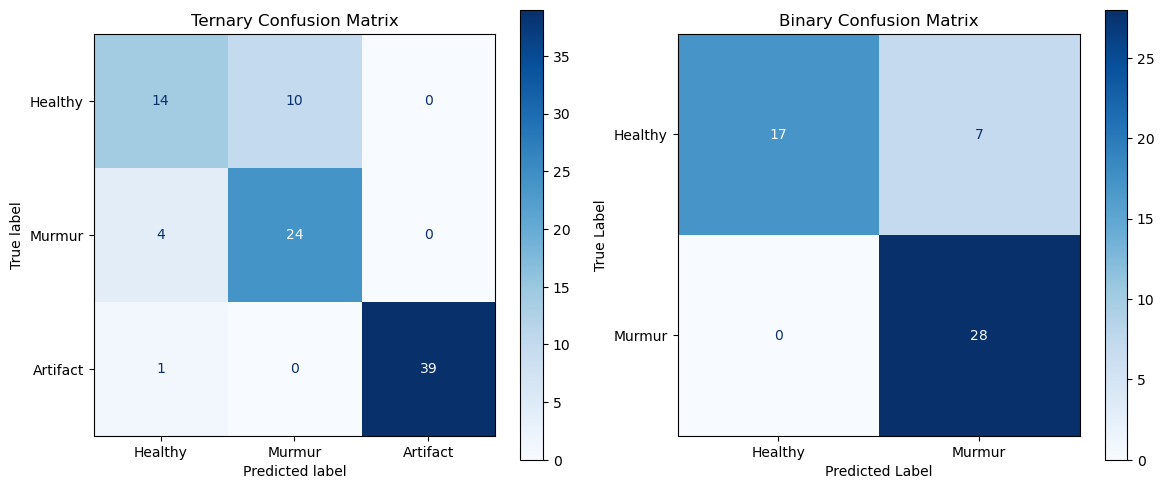

Stage 2 classifer, Healthy precision: 1.0
Stage 2 classifier, Murmur precision: 0.8
Stage 2 classifer, Healthy recall: 0.7083333333333334
Stage 2 classifier, Murmur recall: 1.0
Stage 2 classifer, Test macro F1: 0.8590785907859078
Stage 2 classifer, Overall test accuracy: 0.8653846153846154
Stage 2 classifer, Healthy accuracy: 0.7083333333333334
Stage 2 classifer, Murmur accuracy: 1.0


In [43]:

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

#Feature normalization
scaler = StandardScaler()
normalized_train_set = scaler.fit_transform(train_set)
normalized_test_set = scaler.transform(test_set)

#Stage 1: Model training on entire train set using optimal hyperparameters
model_type = study.best_params['model_type']

if model_type == 'svm':
    if study.best_params['kernel'] == 'linear':
        gamma_value = 'scale'  # or whatever you used as default
    else:
        gamma_value = study.best_params['gamma']
    
    class_weight = {
            0: study.best_params['w0'],
            1: study.best_params['w1'],
            2: study.best_params['w2']
        }
    clf = SVC(
        C=study.best_params['C'],
        kernel=study.best_params['kernel'],
        gamma=gamma_value,
        class_weight=class_weight
    )
elif model_type == 'xgboost':
    clf = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        max_depth=study.best_params['max_depth'],
        learning_rate=study.best_params['learning_rate'],
        n_estimators=study.best_params['n_estimators'],
        subsample=study.best_params['subsample'],
        colsample_bytree=study.best_params['colsample_bytree'],
        scale_pos_weight=1  
    )

clf.fit(normalized_train_set, train_set_labels)

#Stage 1: Inference on test set
if model_type == 'xgboost':
    test_set_predict = np.argmax(clf.predict_proba(normalized_test_set), axis=1)
else:
    test_set_predict = clf.predict(normalized_test_set)

#stage 1 Evaluation: F1, Accuracy, Precision, Recall
test_f1 = f1_score(test_set_labels, test_set_predict, average='macro')
print("Stage 1 classifer, Test macro F1:", test_f1)

accuracy = accuracy_score(test_set_labels, test_set_predict)
print("Stage 1 classifer, Overall test accuracy:", accuracy)

healthy_index = np.where(test_set_labels == 0)[0]
accuracy = accuracy_score(test_set_labels[healthy_index], test_set_predict[healthy_index])
print("Stage 1 classifer, Healthy accuracy:", accuracy)
print("healthy sample size:", len(healthy_index))
murmur_index = np.where(test_set_labels == 1)[0]
accuracy = accuracy_score(test_set_labels[murmur_index], test_set_predict[murmur_index])
print("Stage 1 classifer, Murmur accuracy:", accuracy)
print("murmur sample size:", len(murmur_index))
artifact_index = np.where(test_set_labels == 2)[0]
accuracy = accuracy_score(test_set_labels[artifact_index], test_set_predict[artifact_index])
print("Stage 1 classifer, Artifact accuracy:", accuracy)
print("artifact sample size:", len(artifact_index))

#Confusion matrix 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(test_set_labels, test_set_predict, labels=[0,1,2])
class_names = ['Healthy', 'Murmur', 'Artifact']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=axs[0], cmap='Blues', values_format='d')  
axs[0].set_title('Ternary Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

precision = precision_score(test_set_labels, test_set_predict, average=None)
recall = recall_score(test_set_labels, test_set_predict, average=None)

print('Stage 1 classifer, Healthy precision:', precision[0])
print('Stage 1 classifier, Murmur precision:', precision[1])
print('Stage 1 classifier, Artifact precision:', precision[2])

print('Stage 1 classifer, Healthy recall:', recall[0])
print('Stage 1 classifier, Murmur recall:', recall[1])
print('Stage 1 classifier, Artifact recall:', recall[2])


model_type = study_secondary_classifier.best_params['model_type']
if model_type == 'svm':
    if study_secondary_classifier.best_params['kernel'] == 'linear':
        gamma_value = 'scale' 
    else:
        gamma_value = study_secondary_classifier.best_params['gamma']
    
    class_weight = {
            0: study_secondary_classifier.best_params['w0'],
            1: study_secondary_classifier.best_params['w1']
        }
    clf = SVC(
        C=study_secondary_classifier.best_params['C'],
        kernel=study_secondary_classifier.best_params['kernel'],
        gamma=gamma_value,
        class_weight=class_weight
    )
elif model_type == 'xgboost':
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='mlogloss',
        max_depth=study_secondary_classifier.best_params['max_depth'],
        learning_rate=study_secondary_classifier.best_params['learning_rate'],
        n_estimators=study_secondary_classifier.best_params['n_estimators'],
        subsample=study_secondary_classifier.best_params['subsample'],
        colsample_bytree=study_secondary_classifier.best_params['colsample_bytree'],
        scale_pos_weight=1  
    )


#Stage 1: Model training on entire train set using optimal hyperparameters
binary_mask = np.isin(train_set_labels, [0,1])
binary_train_set = normalized_train_set[binary_mask]
binary_train_labels = train_set_labels[binary_mask]
clf.fit(binary_train_set, binary_train_labels)

#Stage 2: Inference on test set
binary_mask = np.isin(test_set_labels, [0,1])
binary_test_set = normalized_test_set[binary_mask]
binary_test_labels = test_set_labels[binary_mask]
test_set_predict = clf.predict(binary_test_set)

#stage 2 Evaluation: F1, Accuracy, Precision, Recall
cm = confusion_matrix(binary_test_labels, test_set_predict, labels=[0,1])
class_names = ['Healthy', 'Murmur']
disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp_binary.plot(ax=axs[1],cmap='Blues', values_format='d')  
axs[1].set_title('Binary Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=300)
plt.show()

precision = precision_score(binary_test_labels, test_set_predict, average=None)
recall = recall_score(binary_test_labels, test_set_predict, average=None)

print('Stage 2 classifer, Healthy precision:', precision[0])
print('Stage 2 classifier, Murmur precision:', precision[1])

print('Stage 2 classifer, Healthy recall:', recall[0])
print('Stage 2 classifier, Murmur recall:', recall[1])

test_f1 = f1_score(binary_test_labels, test_set_predict, average='macro')
print("Stage 2 classifer, Test macro F1:", test_f1)

accuracy = accuracy_score(binary_test_labels, test_set_predict)
print("Stage 2 classifer, Overall test accuracy:", accuracy)

healthy_index = np.where(test_set_labels == 0)[0]
accuracy = accuracy_score(binary_test_labels[healthy_index], test_set_predict[healthy_index])
print("Stage 2 classifer, Healthy accuracy:", accuracy)
murmur_index = np.where(test_set_labels == 1)[0]
accuracy = accuracy_score(binary_test_labels[murmur_index], test_set_predict[murmur_index])
print("Stage 2 classifer, Murmur accuracy:", accuracy)


# Features analyses: discriminability

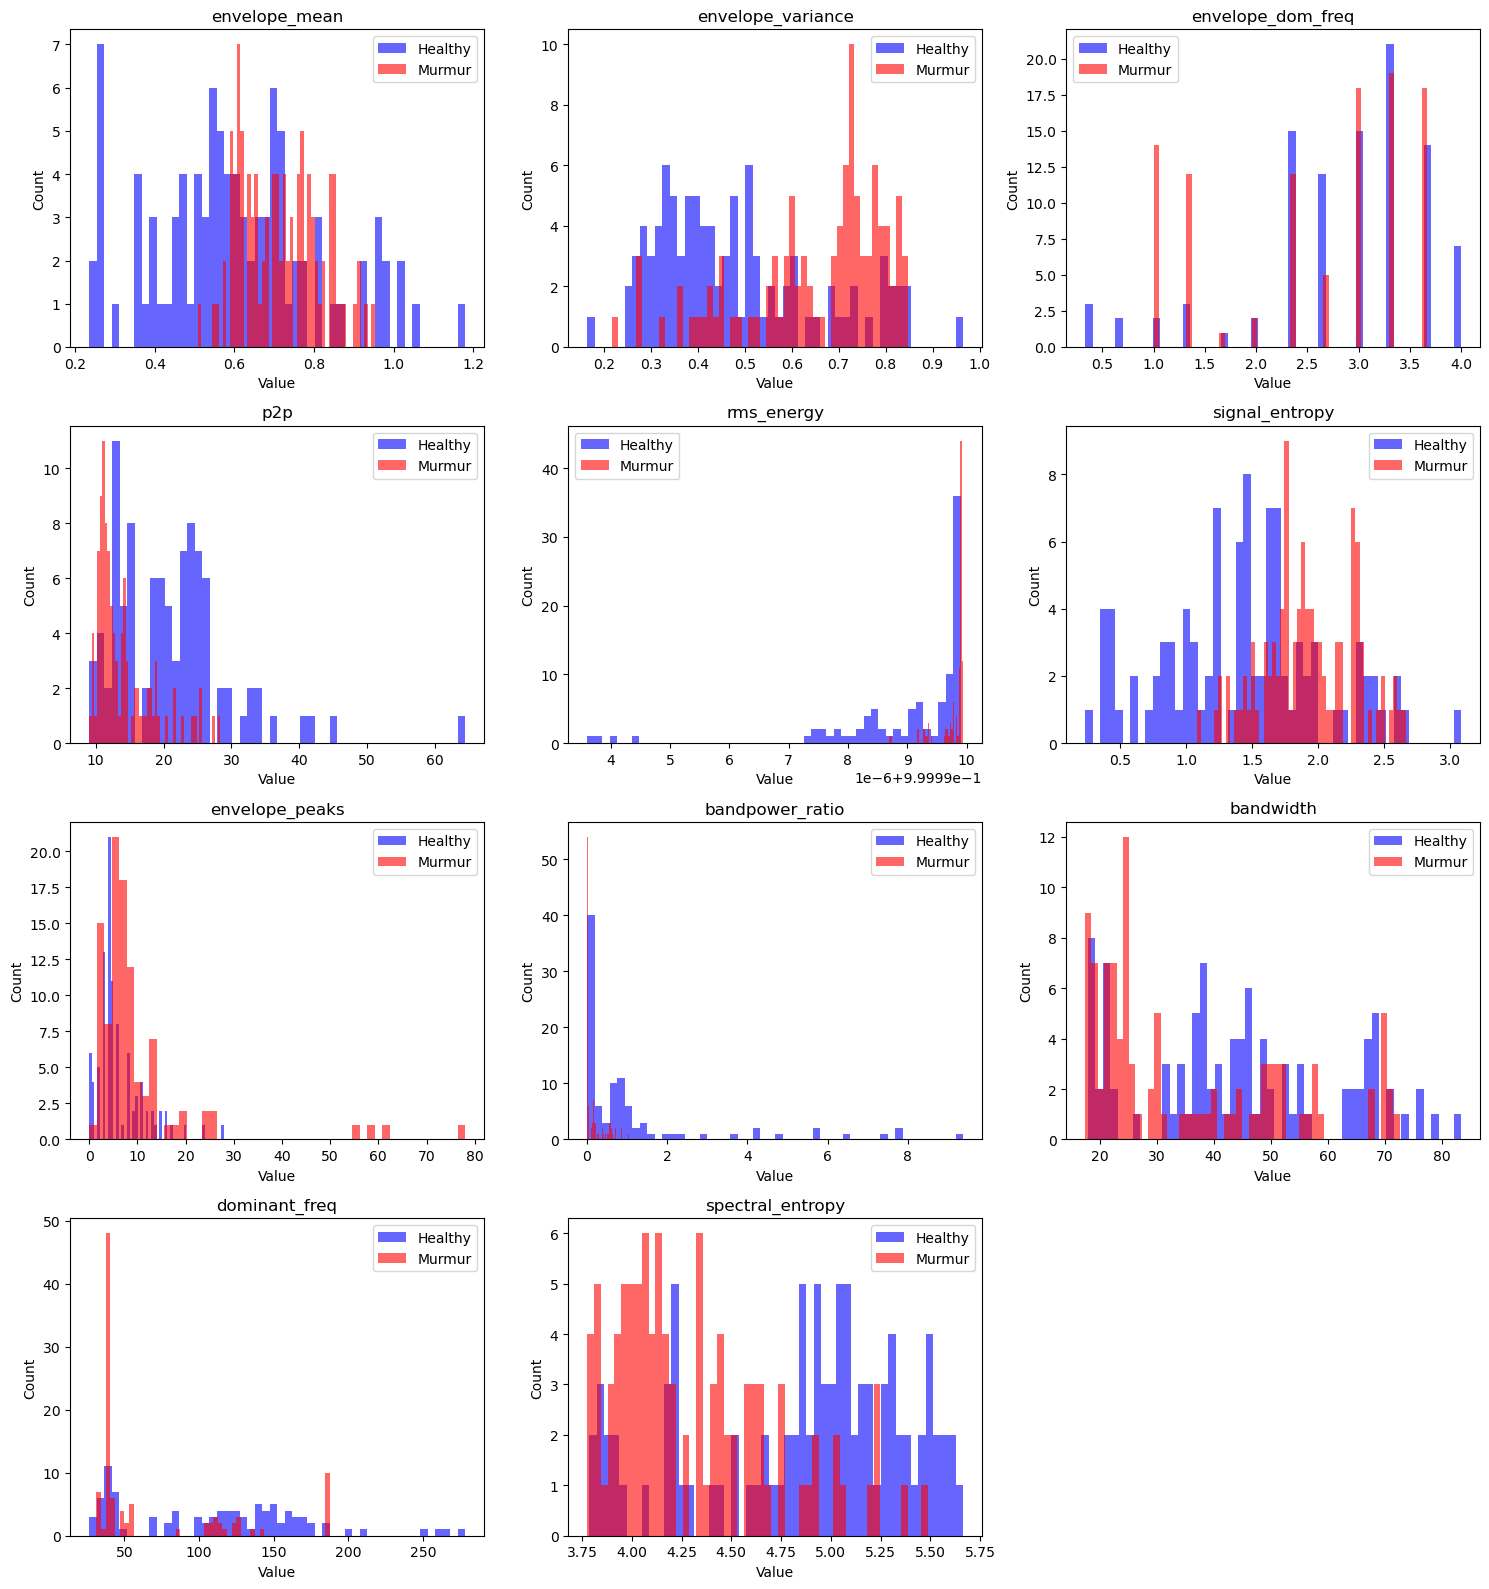

envelope_mean - cohen_d: -0.6959776418428443
envelope_variance - cohen_d: -1.0646171384764396
envelope_dom_freq - cohen_d: 0.2865700857989923
p2p - cohen_d: 1.0634298825306876
rms_energy - cohen_d: -0.8398471054134776
signal_entropy - cohen_d: -0.9964270005633965
envelope_peaks - cohen_d: -0.41082060308423923
bandpower_ratio - cohen_d: 0.7144736757215935
bandwidth - cohen_d: 0.5388664133887853
dominant_freq - cohen_d: 0.7736476157750376
spectral_entropy - cohen_d: 1.205220583219691


In [44]:
#Per feature histogram analyses, Healthy vs Murmur
n_features = train_set.shape[1]
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

feature_names = ['envelope_mean', 'envelope_variance', 'envelope_dom_freq', 'p2p', 'rms_energy', 'signal_entropy', 'envelope_peaks', 
                'bandpower_ratio', 'bandwidth', 'dominant_freq', 'spectral_entropy']

for feature_id in range (train_set.shape[1]):
    feature_healthy = train_set[train_set_labels == 0,feature_id]
    feature_murmur = train_set[train_set_labels == 1,feature_id]
    plt.subplot(n_rows, n_cols, feature_id + 1)
    plt.hist(feature_healthy, bins=50, alpha=0.6, label='Healthy', color='blue')
    plt.hist(feature_murmur, bins=50, alpha=0.6, label='Murmur', color='red')
    plt.title(feature_names[feature_id])
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.savefig("Features_analyses.png", dpi=300)
plt.show()


#Statistically, are features separable between classes?
def cohen_d(x1, x2):
    return (np.mean(x1) - np.mean(x2)) / np.sqrt((np.std(x1)**2 + np.std(x2)**2)/2)

#Per feature cohen's d analysis, Healthy vs Murmur
for feature_id in range (train_set.shape[1]):
    feature_healthy = train_set[train_set_labels == 0,feature_id]
    feature_murmur = train_set[train_set_labels == 1,feature_id]
    print(f"{feature_names[feature_id]} - cohen_d: {cohen_d(feature_healthy, feature_murmur)}")



# Features analyses: Time domain

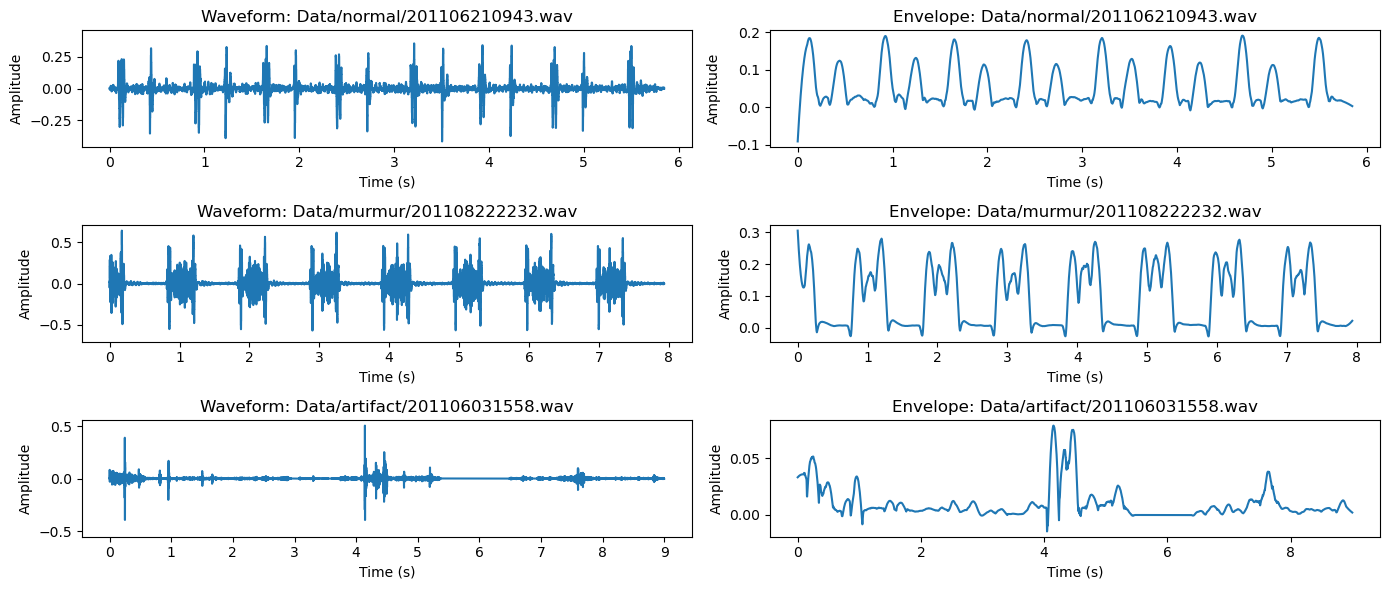

In [45]:

from scipy.signal import hilbert, find_peaks
from scipy.signal import savgol_filter
from scipy.stats import entropy as scipy_entropy
from scipy.signal import welch

#Time domain visualizations to inform features
def process_and_plot_time(ax_wave, ax_env, filepath, lowcut, highcut, sr, order):
    # Load files and preprocess
    y, _ = librosa.load(filepath, sr=sr)
    bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)
    time = np.arange(len(bpf_output)) / sr

    # Compute envelope hilbert
    envelope = np.abs(hilbert(bpf_output))
    smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)

    # Plot bandpass filtered waveform
    librosa.display.waveshow(bpf_output, sr=sr, ax=ax_wave)
    ax_wave.set_title(f'Waveform: {filepath}')
    ax_wave.set_xlabel('Time (s)')
    ax_wave.set_ylabel('Amplitude')

    # Plot smoothed envelope
    ax_env.plot(time, smoothed_env)
    ax_env.set_title(f'Envelope: {filepath}')
    ax_env.set_xlabel('Time (s)')
    ax_env.set_ylabel('Amplitude')

# Set parameters
lowcut = 20
highcut = 400
sr = 1000
order = 4

files = [
    'Data/normal/201106210943.wav',
    'Data/murmur/201108222232.wav', 
    'Data/artifact/201106031558.wav'   
]

fig, axs = plt.subplots(3, 2, figsize=(14, 6))

for i, filepath in enumerate(files):
    row = i
    process_and_plot_time(axs[row, 0], axs[row, 1], filepath, lowcut, highcut, sr, order)

plt.tight_layout()
plt.savefig("waveform_envelopes.png", dpi=300)
plt.show()



# Feature analyses: frequency domain

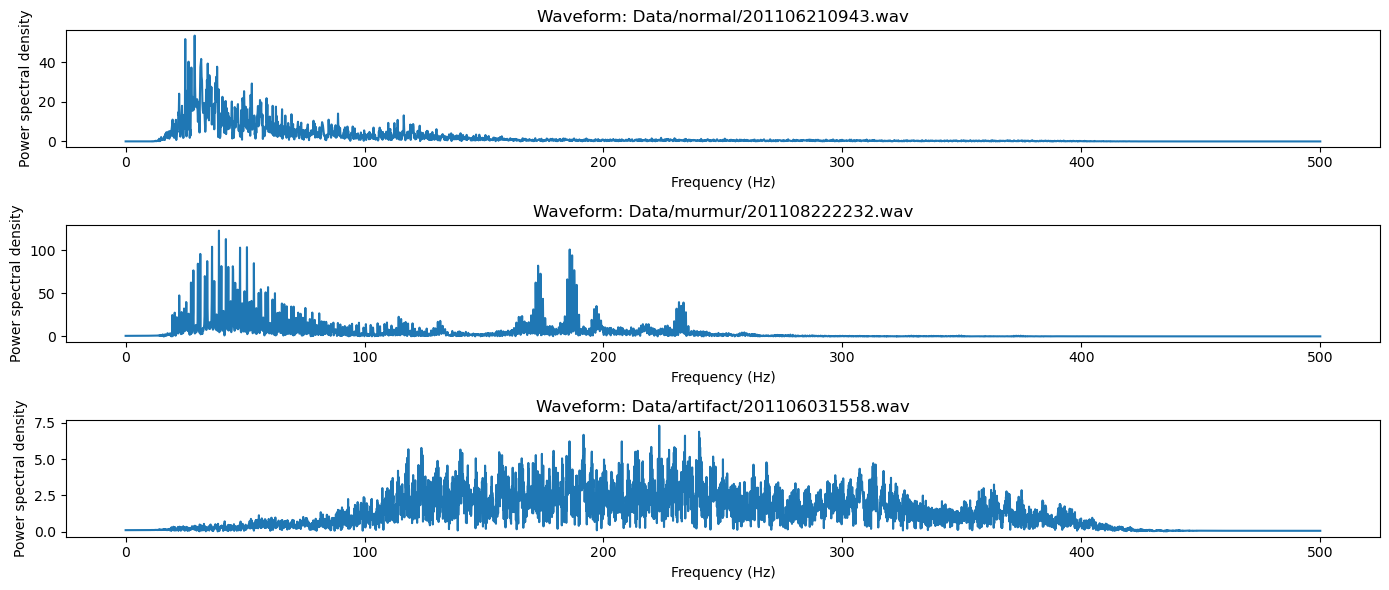

In [46]:
#Frequency domain (psd) visualizations to inform features
def process_and_plot_frequency(ax_wave, filepath, lowcut, highcut, sr, order):
    # Load and preprocess
    y, _ = librosa.load(filepath, sr=sr)
    bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)

    #Compute PSD
    N = len(bpf_output)
    freqs = np.fft.rfftfreq(N, 1/sr)
    fft_vals = np.abs(np.fft.rfft(bpf_output))
    ax_wave.plot(freqs, fft_vals)
    ax_wave.set_title(f'Waveform: {filepath}')
    ax_wave.set_xlabel('Frequency (Hz)')
    ax_wave.set_ylabel('Power spectral density')

# Set parameters
lowcut = 20
highcut = 400
sr = 1000
order = 4

files = [
    'Data/normal/201106210943.wav',
    'Data/murmur/201108222232.wav', 
    'Data/artifact/201106031558.wav'   
]

fig, axs = plt.subplots(3, 1, figsize=(14, 6))

for i, filepath in enumerate(files):
    row = i
    process_and_plot_frequency(axs[row], filepath, lowcut, highcut, sr, order)

plt.tight_layout()
plt.savefig("psds.png", dpi=300)
plt.show()


# Features analyses: time frequency domain

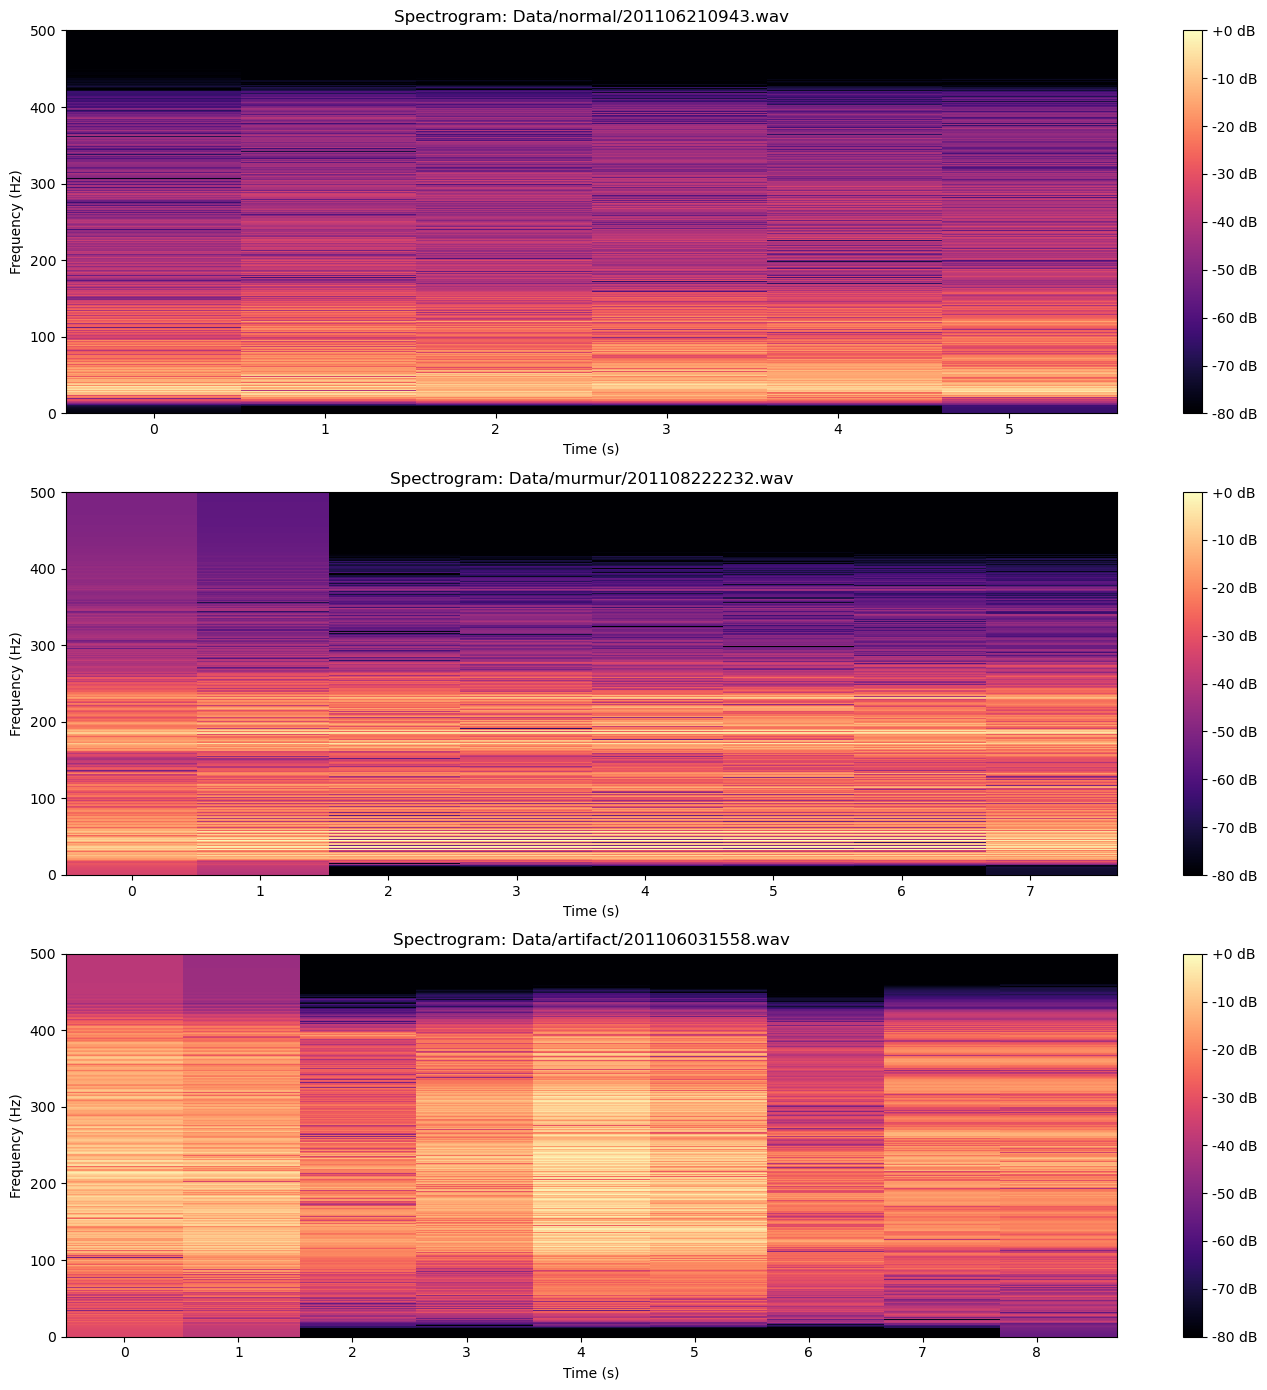

In [47]:
#Time Frequency domain visualizations to inform features

def plot_spectrogram(ax_wave, filepath, lowcut, highcut, sr, order):
    #load file and preprocess
    y, _ = librosa.load(filepath, sr=sr)
    bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)
    n_fft = 4096  
    hop_length = n_fft // 4  
    #Time frequency computation via stft
    D = librosa.amplitude_to_db(np.abs(librosa.stft(bpf_output, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=ax_wave, hop_length=hop_length)
    ax_wave.set_title(f'Spectrogram: {filepath}')
    ax_wave.set_xlabel('Time (s)')
    ax_wave.set_ylabel('Frequency (Hz)')
    plt.colorbar(img, ax=ax_wave, format="%+2.0f dB")

lowcut = 20
highcut = 400
sr = 1000
order = 4

files = [
    'Data/normal/201106210943.wav',
    'Data/murmur/201108222232.wav', 
    'Data/artifact/201106031558.wav'   
]

fig, axs = plt.subplots(3, 1, figsize=(14, 14))

for i, filepath in enumerate(files):
    row = i
    plot_spectrogram(axs[row], filepath, lowcut, highcut, sr, order)

plt.tight_layout()
plt.savefig("spectrograms.png", dpi=300)
plt.show()

In [33]:
import pkg_resources

with open("clean_requirements.txt", "w") as f:
    for dist in pkg_resources.working_set:
        try:
            line = f"{dist.project_name}=={dist.version}\n"
            f.write(line)
        except Exception:
            pass

/tmp/ipykernel_1930037/815861703.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
